# Imports

In [1]:
import torch
import pandas as pd
import os
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

In [2]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

In [3]:
import pandas as pd
pd.options.display.max_columns = None

In [4]:
%run ../mimic_cxr.py

# Load metadata

In [ ]:
FNAME_PREFIX = 'mimic-cxr-2.0.0'

In [ ]:
fpath = os.path.join(DATASET_DIR, f'{FNAME_PREFIX}-metadata.csv')
metadata = pd.read_csv(fpath)
metadata.head()

In [ ]:
fpath = os.path.join(DATASET_DIR, f'{FNAME_PREFIX}-chexpert.csv')
chexpert_df = pd.read_csv(fpath)
chexpert_df.fillna(0, inplace=True)
chexpert_df.replace(-1, 1, inplace=True)
chexpert_df.head()

# Plot example

In [ ]:
from PIL import Image

In [ ]:
idx = -1001
row = metadata.iloc[idx]
row

In [ ]:
subject_id = f'p{row["subject_id"]}'
study_id = f's{row["study_id"]}'
dicom_id = str(row['dicom_id'])
image_fname = f'{dicom_id}.jpg'
subfolder = subject_id[:3]
subfolder, subject_id, study_id, image_fname

In [ ]:
image_fpath = os.path.join(DATASET_DIR, 'images', subfolder, subject_id, study_id, image_fname)

In [ ]:
image = Image.open(image_fpath)
print(image.size)
plt.imshow(image, cmap='gray')

In [ ]:
report_fpath = os.path.join(DATASET_DIR, 'reports', subfolder, subject_id, f'{study_id}.txt')

In [ ]:
with open(report_fpath) as f:
    text = f.read()
print(text)

# Pre-process

i.e. run only once

## Create master csv

### Keep only studies with a report present

In [ ]:
%run -n ../preprocess/mimic_cxr.py

In [ ]:
reports_df = load_raw_reports_df()
reports_df.head()

In [ ]:
studies_with_report = set(int(report[1:]) for report in reports_df['study'])
len(studies_with_report)

### Check metadata vs chexpert discrepancies

* Only studies with a report are kept
* There are a few studies with no report, present in metadata and chexpert_df csvs

In [ ]:
len(metadata), len(chexpert_df)

In [ ]:
studies1 = set(metadata['study_id'])
studies2 = set(chexpert_df['study_id'])
len(studies1), len(studies2), studies2.issubset(studies1)

In [ ]:
studies11 = studies1.intersection(studies_with_report)
studies22 = studies2.intersection(studies_with_report)
len(studies11), len(studies22), studies11 == studies22

### Merge metadata and chexpert

In [ ]:
metadata_filtered = metadata.loc[metadata['study_id'].isin(studies_with_report)]
len(metadata_filtered), len(set(metadata_filtered['study_id']))

In [ ]:
chexpert_filtered = chexpert_df.loc[chexpert_df['study_id'].isin(studies_with_report)]
len(chexpert_filtered), len(set(chexpert_filtered['study_id']))

In [ ]:
studies1 = set(metadata_filtered['study_id'])
studies2 = set(chexpert_filtered['study_id'])
assert studies1 == studies2

In [ ]:
master_df = metadata_filtered.merge(
    chexpert_filtered, on=['study_id', 'subject_id'], how='inner')
len(master_df), len(set(master_df['study_id']))

In [ ]:
master_df.head()

### Merge with split

In [ ]:
fpath = os.path.join(DATASET_DIR, f'{FNAME_PREFIX}-split.csv')
split_df = pd.read_csv(fpath)
split_df.head()

In [ ]:
master_df = master_df.merge(split_df, on=['dicom_id', 'study_id', 'subject_id'], how='inner')
len(master_df), len(set(master_df['study_id']))

In [ ]:
master_df.head()

### Add filepaths

In [ ]:
def get_filenames(subject_id, study_id, dicom_id):
    subject_id = f'p{subject_id}'
    study_id = f's{study_id}'
    image_fname = f'{dicom_id}.jpg'
    subfolder = subject_id[:3]

    image_fpath = os.path.join(subfolder, subject_id, study_id, image_fname)
    report_fpath = os.path.join(subfolder, subject_id, f'{study_id}.txt')
    
    return image_fpath, report_fpath

In [ ]:
image_fpaths, report_fpaths = zip(*[
    get_filenames(*ids)
    for ids in zip(master_df['subject_id'], master_df['study_id'], master_df['dicom_id'])
])
len(image_fpaths), len(report_fpaths)

In [ ]:
master_df['image_fpath'] = image_fpaths
master_df['report_fpath'] = report_fpaths

In [ ]:
master_df.head()

### Check lateral or frontal

In [ ]:
master_df.head()

#### Check weird positions 

In [ ]:
positions = list(Counter(master_df['ViewPosition']).keys())
positions

In [ ]:
weird_pos = positions[5:]
weird_pos

In [ ]:
cols = ['image_fpath',
        'ViewPosition', 'PerformedProcedureStepDescription', 'ViewCodeSequence_CodeMeaning',
        # 'dicom_id',
       ]
df = master_df[cols]
weird_images = df.loc[df['ViewPosition'].isin(weird_pos)]
print(len(weird_images))

In [ ]:
weird_images.sort_values('ViewPosition')

In [ ]:
' '.join(list(weird_images['image_fpath']))

In [ ]:
FRONTAL_POSITIONS = ['PA', 'AP', 'AP AXIAL', 'LAO', 'LPO', 'RAO']

#### Check nan positions

FIXME: For now, samples with ViewPosition == nan, maybe frontal or lateral

In [ ]:
Counter(master_df['ViewPosition'])

In [ ]:
cols = ['image_fpath',
        'ViewPosition', 'PerformedProcedureStepDescription', 'ViewCodeSequence_CodeMeaning',
        # 'dicom_id',
       ]
df = master_df[cols]
nan_positions = df.loc[df['ViewPosition'].isnull()]
len(nan_positions)

In [ ]:
nan_positions['ViewCodeSequence_CodeMeaning'].isnull().sum()

In [ ]:
' '.join(list(nan_positions['image_fpath'])[:10])

### Save master csv

In [ ]:
%run ../common/__init__.py

In [ ]:
cols = ['dicom_id', 'subject_id', 'study_id',
        'image_fpath', 'report_fpath',
        'ViewPosition', 'split',
        ] + CHEXPERT_DISEASES

In [ ]:
out_df = master_df[cols]
out_df.replace('validate', 'val', inplace=True)
out_df.head()

In [ ]:
len(out_df), len(set(out_df['subject_id'])), len(set(out_df['study_id']))

In [ ]:
Counter(out_df['split'])

In [ ]:
fpath = os.path.join(DATASET_DIR, 'master_metadata.csv')
out_df.to_csv(fpath, index=False)

## Clean and tokenize reports

### Debug tokenizer

#### Review reports/sentences manually

In [10]:
import re

In [3]:
%run ../../utils/nlp.py
%run ../mimic_cxr.py

In [4]:
reports_fname = os.path.join(DATASET_DIR, 'reports', 'reports.clean.v1.json')
with open(reports_fname, 'r') as f:
    reports = json.load(f)

In [5]:
token_appearances = Counter()
for r in reports.values():
    for token in r['clean_text'].split():
        token_appearances[token] += 1
len(token_appearances)

11146

In [6]:
def find_reports_with_tokens(tokens):
    if isinstance(tokens, str):
        tokens = [tokens]
    found = []
    for report in reports.values():
        text = report['clean_text']
        
        for token in tokens:
            if re.search(token, text):
                found.append(report)
                break
                
    return found

In [7]:
sentences_appears = get_sentences_appearances(r['clean_text'] for r in reports.values())
sentences = list(sentences_appears)
len(sentences)

361265

In [8]:
sentences[100:200]

['there is upper zone redistribution and cardiomegaly suggesting pulmonary venous hypertension .',
 'there is no pneumothorax .',
 'in comparison with the study of xxxx , the increased opacification at the right base has essentially cleared with better inspiration .',
 'cardiac silhouette remains at the upper limits of normal in size and there is again tortuosity of the aorta without vascular congestion or pleural effusion .',
 'biapical changes , especially on the right , are stable .',
 'this ascending aorta is unchanged .',
 'lungs are essentially clear except for chronic interstitial changes bilaterally .',
 'the findings might be attributed to the provided history of copd .',
 'if clinically warranted , correlation with cross-sectional imaging might be considered .',
 'no pleural effusion or pneumothorax is seen .',
 'right middle lobe opacity concerning for pneumonia .',
 'mild basilar atelectasis without definite focal consolidation .',
 'no evidence of pneumonia .',
 'no focal 

In [11]:
found = [s for s in sentences if re.search(r'\A\W', s)]
len(found)

7

In [12]:
found

[', xxxx into xxxx a pre-existing left pleural effusion has massively increased .',
 '? infiltrate vs .',
 '.',
 ', the right base is essentially clear .',
 '? tiny left apical pneumothorax .',
 '- no acute cardiopulmonary process .',
 ', the orogastric tube is been pushed forward so that the tip extends at least to the lower body of the stomach , with the side port well beyond the esophagogastric junction .']

In [13]:
[k for k in token_appearances.keys() if re.search(r'\A\W+', k)]

['.', ',', '(', ')', '-', '?', '#', '+']

In [25]:
found = find_reports_with_tokens(r'(\. |\A)[\?,\-]')
len(found)

6

In [26]:
found

[{'study_id': 54164300,
  'clean_text': ', xxxx into xxxx a pre-existing left pleural effusion has massively increased . the effusion now occupies approximately NUMBER of the left hemi thorax . there is mild displacement of the heart and the mediastinum to the right . extensive left lower lobe atelectasis . unchanged normal appearance of the right lung . the right pectoral pacemaker and the hemodialysis catheter are in correct position .',
  'text': ', ___ into ___ a pre-existing left pleural effusion has massively\n increased.  The effusion now occupies approximately ___% of the left hemi\n thorax.  There is mild displacement of the heart and the mediastinum to the\n right.  Extensive left lower lobe atelectasis.  Unchanged normal appearance of\n the right lung.  The right pectoral pacemaker and the hemodialysis catheter\n are in correct position.'},
 {'study_id': 56010602,
  'clean_text': '? infiltrate vs . atelectasis right mid lung .',
  'text': '? infiltrate vs. atelectasis right 

#### Actually debug tokenizer

In [41]:
%run ../preprocess/tokenize.py

In [45]:
ts = text_to_tokens('. , alsdka s ña,s , ? PA & lat')
ts

['alsdka', 's', 'ña', ',', 's', ',', '?', 'pa', 'and', 'lat', '.']

In [40]:
ts = ['a', 'b', 'c', '.']
ts = []
next(filter(lambda i: _VALID_WORD_TOKEN.search(ts[i]), range(len(ts))), 0)

0

In [30]:
ts.find(3)

AttributeError: 'list' object has no attribute 'find'

### Run preprocess

In [1]:
%run -n ../preprocess/mimic_cxr.py

In [2]:
reports, token_appearances, errors = preprocess_mimic_cxr()
len(reports), len(token_appearances)

  0%|          | 0/227827 [00:00<?, ?it/s]

Errors:  {}
Different tokens:  11148
Saved reports to:  /mnt/data/mimic-cxr-jpg/reports/reports.clean.v1.json


(227827, 11148)

### Some utils

In [8]:
REPORTS_DF = load_raw_reports_df()
REPORTS_DF.head()

,study,text,impression,findings,last_paragraph,comparison
0,s53911762,No acute intrathoracic process.,No acute intrathoracic process.,Single frontal view of the chest provided.\n \...,NaN,Chest radiograph ___
1,s56699142,No acute cardiopulmonary process.,No acute cardiopulmonary process.,"The lungs are clear of focal consolidation, pl...",NaN,"Radiographs from ___, ___ and ___."
2,s53189527,No acute cardiopulmonary abnormality.,No acute cardiopulmonary abnormality.,"The cardiac, mediastinal and hilar contours ar...",NaN,___
3,s50414267,No acute cardiopulmonary process.,No acute cardiopulmonary process.,"There is no focal consolidation, pleural effus...",NaN,None.
4,s57375967,"Focal consolidation at the left lung base, pos...","Focal consolidation at the left lung base, pos...",PA and lateral views of the chest provided. ...,NaN,None


In [78]:
fpath = os.path.join(DATASET_DIR, 'master_metadata.csv')
master_df = pd.read_csv(fpath)
master_df.head(2)

,dicom_id,subject_id,study_id,image_fpath,report_fpath,ViewPosition,split,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,...,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,report_length
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032,50414267,p10/p10000032/s50414267/02aa804e-bde0afdd-112c...,p10/p10000032/s50414267.txt,PA,train,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,10000032,50414267,p10/p10000032/s50414267/174413ec-4ec4c1f7-34ea...,p10/p10000032/s50414267.txt,LATERAL,train,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [6]:
def load_raw_report(study_id):
    if isinstance(study_id, str):
        study_id = int(study_id.strip('s'))

    d = master_df.loc[master_df['study_id'] == study_id]
    
    report_fpaths = list(d['report_fpath'].unique())
    assert len(report_fpaths) == 1, f'Not 1 subject: {report_fpaths}'
    report_fpath = report_fpaths[0]
    print(report_fpath)
    report_fpath = os.path.join(DATASET_DIR, 'raw-reports', report_fpath)
    
    with open(report_fpath) as f:
        text = f.read()
    
    return text

### Check errors

#### Check wrong reports

In [ ]:
studies = list(f's{s}' for s in errors['tokens-empty'])
len(studies)

In [ ]:
for study_id in studies:
    print('=' * 60)
    print('Study ID: ', study_id)

    report = load_raw_report(study_id)
    print(report)

    print('-' * 30)

    d = REPORTS_DF.loc[REPORTS_DF['study'] == study_id]
    ids = list(d.index)
    assert len(ids) == 1, f'Not 1 study: {d}'
    d = d.loc[ids[0]]
    for k in ['text', 'comparison', 'findings', 'impression', 'last_paragraph']:
        print(f'{k}: {d[k]}')

    print('=' * 60)

#### Check tokens

In [41]:
sorted([(k, v) for k, v in token_appearances.items()], key=lambda x: x[1], reverse=True)

[('.', 700496),
 ('the', 428366),
 ('of', 232669),
 (',', 224377),
 ('is', 214079),
 ('no', 192578),
 ('in', 159873),
 ('and', 136040),
 ('right', 125472),
 ('to', 108014),
 ('left', 102973),
 ('pleural', 97854),
 ('with', 94405),
 ('there', 86204),
 ('xxxx', 84486),
 ('are', 79342),
 ('pulmonary', 70949),
 ('lung', 69282),
 ('effusion', 63616),
 ('acute', 61677),
 ('a', 56007),
 ('atelectasis', 55243),
 ('pneumothorax', 53435),
 ('tube', 52518),
 ('edema', 50330),
 ('or', 49641),
 ('pneumonia', 49186),
 ('chest', 49122),
 ('unchanged', 47430),
 ('at', 46208),
 ('be', 42095),
 ('process', 40934),
 ('cardiopulmonary', 39842),
 ('has', 39593),
 ('on', 39550),
 ('evidence', 38615),
 ('mild', 37694),
 ('lower', 37093),
 ('small', 36364),
 ('compared', 35434),
 ('as', 34885),
 ('study', 33916),
 ('comparison', 33057),
 ('size', 32279),
 ('effusions', 32241),
 ('normal', 31066),
 ('lobe', 30006),
 ('NUMBER', 29763),
 ('radiograph', 29351),
 ('moderate', 28209),
 ('tip', 27404),
 ('cardiac', 

In [42]:
found = find_reports_with_tokens(r'\# NUMBER')
len(found)

0

In [88]:
found[0]

{'study_id': 59977695,
 'clean_text': 'bibasilar reticulonodular opacities , slightly decreased on the right and increased on the left compared to prior radiograph from xxxx , concerning for a multifocal infectious process . persistent rightward deviation of the trachea at the level of the clavicular heads , raising concern for right thyroid enlargement . if not already performed , a non-emergent thyroid ultrasound could provide further information . impression point # NUMBER was discussed with doctor xxxx by doctor xxxx at NUMBER via telephone on the day of the study .',
 'text': '1.  Bibasilar reticulonodular opacities, slightly decreased on the right and\n increased on the left compared to prior radiograph from ___,\n concerning for a multifocal infectious process.\n \n 2.  Persistent rightward deviation of the trachea at the level of the\n clavicular heads, raising concern for right thyroid enlargement.  If not\n already performed, a non-emergent thyroid ultrasound could provide fu

In [47]:
[k for k in token_appearances.keys() if re.search(r'\A\W+', k)]

['.',
 ',',
 ':',
 '/',
 '(',
 ')',
 '-',
 ',?',
 '"round"',
 '%',
 '\\small',
 '?',
 '"butterfly"',
 "'s",
 ',.',
 '"no',
 '"water',
 '#',
 '?consolidation',
 '"wedge',
 '"',
 '"chf',
 '"apical',
 ',"',
 '=',
 './',
 '~',
 '?atelectasis',
 '"hairpin"',
 '"right',
 '"worsening',
 '"round',
 '&',
 '?small',
 "'subclavian",
 '`difficult',
 "'wetread",
 '%.',
 '-?',
 "'\\s",
 '"second',
 '\\pneumonia',
 '"spine',
 '."',
 '***',
 '?technical',
 '"asthma"',
 '"nodule"',
 '"left',
 '"patient',
 '"new',
 '"cardiac',
 '?calcified',
 '"lymphadenopathy"',
 '.\\',
 '+/-',
 '?right',
 '?to',
 ':follow',
 '.:',
 '"bb".',
 '"ed',
 ':followup',
 '?mediastinal',
 '"atypical".',
 '"saber-shaped"',
 '\\with',
 '"upright"',
 '"pagetoid"',
 ',,',
 '?.',
 '*right',
 '?pulmonary',
 '"pneumonia"',
 '~NUMBER',
 '\\moderate',
 '?scarring',
 '=w']

In [43]:
sorted([(k, v) for k, v in token_appearances.items()], key=lambda x: x[1])

[('inmoderate', 1),
 ('diaphragm:', 1),
 ('re-developed', 1),
 ('reflectiing', 1),
 ('osteoporotic?', 1),
 ('attributes', 1),
 ('telehpone', 1),
 ('arytenoid', 1),
 ('interrupting', 1),
 ('prompting', 1),
 ('magnets', 1),
 ('addedd', 1),
 ('finely', 1),
 ('ailment', 1),
 ('antibioic', 1),
 ('lsca', 1),
 ('subtends', 1),
 ('s-g', 1),
 ('proximalmost', 1),
 ('invariably', 1),
 ('chronologically', 1),
 ('imag', 1),
 ('ive', 1),
 ('chsst', 1),
 ('readiograph', 1),
 ('intussusception', 1),
 ('refect', 1),
 ('intraatrial', 1),
 ('mid-portion', 1),
 ('regardomg', 1),
 ('deployed', 1),
 ('consistence', 1),
 ('pheochromocytoma', 1),
 ('achieved:', 1),
 ('confounded', 1),
 ('severe:', 1),
 ('potentiallymight', 1),
 ('likely2', 1),
 ('bbibasilar', 1),
 ('follwing', 1),
 ('noncompliance', 1),
 ('pre-intubation', 1),
 ('intra-intrathoracic', 1),
 ('opacifaction', 1),
 ('fungemia', 1),
 ('opacityfor', 1),
 ('hemicolectomy', 1),
 ('possiblle', 1),
 ('clinnically', 1),
 ('hemangioma', 1),
 ('echinococ

## Calculate mean and std

In [ ]:
%run ../mimic_cxr.py
%run ../../utils/images.py

In [ ]:
fpath = os.path.join(DATASET_DIR, 'master_metadata.csv')
d = pd.read_csv(fpath)
d = d.loc[d['split'] == 'train']
train_images = list(d['image_fpath'].unique())
len(train_images)

In [ ]:
image_folder = os.path.join(DATASET_DIR, 'images')

In [ ]:
%%capture output
%%time

mean, std = compute_mean_std(ImageFolderIterator(image_folder, train_images), show=True)
mean, std

In [ ]:
mean, std

## Sentence2organ

In [1]:
import json

In [15]:
%run ../mimic_cxr.py
%run ../common/sentences2organs/compute.py
%run ../common/constants.py
%run ../../utils/nlp.py

In [5]:
reports_fname = os.path.join(DATASET_DIR, 'reports', 'reports.clean.v1.json')
with open(reports_fname, 'r') as f:
    reports = list(json.load(f).values())
len(reports)

227827

In [6]:
sentences_appears = get_sentences_appearances(r['clean_text'] for r in reports)
sentences = list(sentences_appears)
len(sentences)

361267

In [7]:
total_appearances = sum(sentences_appears.values())
total_appearances

700519

In [16]:
organs_for_sentences, errors = find_organs_for_sentences(sentences, show=True)
len(organs_for_sentences), len(errors['all-empty'])

  0%|          | 0/361267 [00:00<?, ?it/s]

(361267, 52686)

In [17]:
mimic_df = pd.DataFrame(organs_for_sentences, columns=JSRT_ORGANS)
mimic_df['sentences'] = sentences
mimic_df = mimic_df[['sentences'] + JSRT_ORGANS]
mimic_df.head()

,sentences,background,heart,right lung,left lung
0,no acute intrathoracic process .,0,1,1,1
1,no acute cardiopulmonary process .,0,1,1,1
2,no acute cardiopulmonary abnormality .,0,1,1,1
3,"focal consolidation at the left lung base , po...",0,0,0,1
4,central vascular engorgement .,0,1,1,1


### Check empty ones

In [18]:
error_appearances = {
    sentence: sentences_appears[sentence]
    for sentence in errors['all-empty']
}
n_errors = sum(error_appearances.values())
perc = n_errors / total_appearances * 100
f'{n_errors:,}', f'{total_appearances:,}', f'{perc:.0f}%'

('115,276', '700,519', '16%')

In [19]:
l = sorted(error_appearances.items(), key=lambda x: x[1], reverse=True)
l[:10]

[('comparison to xxxx .', 3491),
 ('as compared to the previous radiograph , there is no relevant change .',
  1873),
 ('as compared to the previous radiograph , no relevant change is seen .',
  1560),
 ('no evidence of acute disease .', 1333),
 ('no previous images .', 1257),
 ('portable ap radiograph of the chest was reviewed in comparison to xxxx .',
  1229),
 ('normal chest radiograph .', 1156),
 ('compared to chest radiographs xxxx through xxxx .', 1057),
 ('pa and lateral upright chest radiographs were reviewed in comparison to xxxx .',
  818),
 ('no significant interval change .', 792)]

### Save sentence2organ in file

In [20]:
%run ../../utils/__init__.py
%run ../common/constants.py

In [28]:
from medai.datasets.iu_xray import DATASET_DIR as IU_DATASET_DIR

In [30]:
fpath = os.path.join(IU_DATASET_DIR, 'reports', 'sentences_with_organs_OLD.csv')
iu_df = pd.read_csv(fpath)
iu_df.head()

,sentences,background,heart,right lung,left lung
0,the cardiac silhouette and mediastinum size ar...,0,1,0,0
1,there is no pulmonary edema .,0,0,1,1
2,there is no focal consolidation .,0,0,1,1
3,there are no xxxx of a pleural effusion .,0,0,1,1
4,there is no evidence of pneumothorax .,0,0,1,1


In [33]:
final_df = iu_df.append(mimic_df, ignore_index=True)
len(final_df), len(iu_df) + len(mimic_df)

(367706, 367706)

In [34]:
final_df = final_df.groupby('sentences').last()
final_df.reset_index(drop=False, inplace=True)
print(len(final_df))
final_df.head()

366951


,sentences,background,heart,right lung,left lung
0,"&lt , the heart size and cardiomediastinal sil...",0,1,0,0
1,.,1,1,1,1
2,NUMBER ) .,1,1,1,1
3,"NUMBER , on xxxx .",1,1,1,1
4,"NUMBER , patchy opacities in the right lower l...",0,0,1,0


In [37]:
fpath = os.path.join(WORKSPACE_DIR, 'sentences_with_organs.csv')
final_df.to_csv(fpath, index=False)

# Create mini-mimic

In [98]:
FPATH = os.path.join(DATASET_DIR, 'master_metadata.csv')
df = pd.read_csv(FPATH)
print(len(df))
df.head()

377095


,dicom_id,subject_id,study_id,image_fpath,report_fpath,ViewPosition,split,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,report_length,mini
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032,50414267,p10/p10000032/s50414267/02aa804e-bde0afdd-112c...,p10/p10000032/s50414267.txt,PA,train,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,10000032,50414267,p10/p10000032/s50414267/174413ec-4ec4c1f7-34ea...,p10/p10000032/s50414267.txt,LATERAL,train,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,10000032,53189527,p10/p10000032/s53189527/2a2277a9-b0ded155-c0de...,p10/p10000032/s53189527.txt,PA,train,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0
3,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,10000032,53189527,p10/p10000032/s53189527/e084de3b-be89b11e-20fe...,p10/p10000032/s53189527.txt,LATERAL,train,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,53911762,p10/p10000032/s53911762/68b5c4b1-227d0485-9cc3...,p10/p10000032/s53911762.txt,AP,train,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,1


## Create random split

In [112]:
is_mini = list()
percentages = {
    'train': 0.12,
    'val': 0.15,
    'test': 0.15,
}

for split in ('train', 'val', 'test'):
    sub_df = df.loc[df['split'] == split]
    
    # Do not use images without frontal-lateral definition
    sub_df = sub_df.dropna(axis=0, subset=['ViewPosition'])
    
    images = list(sub_df['dicom_id'])
    k = int(percentages[split] * len(images))
    
    print(f'Choosing {k:,} from {split}')
    is_mini.extend(random.sample(images, k))
len(is_mini)

Choosing 42,435 from train
Choosing 430 from val
Choosing 725 from test


43590

## Add column to master_df

In [113]:
is_mini = set(is_mini)

is_mini_column = [
    int(dicom_id in is_mini)
    for dicom_id in df.dicom_id
]
len(is_mini), len(is_mini_column)

(43590, 377095)

In [114]:
df['mini'] = is_mini_column

In [115]:
df.to_csv(FPATH, index=False)

# Debug Dataset class

In [ ]:
%run ../mimic_cxr.py
%run ../../utils/common.py

In [ ]:
dataset = MIMICCXRDataset('test', sort_samples=True)
len(dataset)

In [ ]:
item = dataset[4]
item.image.size(), item.report

In [ ]:
item.image.min(), item.image.max()

In [ ]:
plt.imshow(tensor_to_range01(item.image).permute(1, 2, 0))

# Plot distributions

In [104]:
%run ../mimic_cxr.py
%run ../../utils/common.py

In [116]:
train_dataset = MIMICCXRDataset('train')
train_dataset_mini = MIMICCXRDataset('train', mini=1)
val_dataset = MIMICCXRDataset('val')
val_dataset_mini = MIMICCXRDataset('val', mini=1)
len(train_dataset), len(train_dataset_mini), len(val_dataset), len(val_dataset_mini)

(368945, 42435, 2991, 430)

In [85]:
def get_dataset_name(dataset):
    if dataset._mini is None:
        return dataset.dataset_type
    return f'mini{dataset._mini}-{dataset.dataset_type}'

## Labels distributions

In [117]:
def plot_labels_distribution(dataset):
    amounts_by_disease = dataset.master_df[CHEXPERT_DISEASES].sum(
        axis=0).sort_values(ascending=False)

    plt.title(get_dataset_name(dataset), fontsize=20)
    plt.bar(amounts_by_disease.index, amounts_by_disease.values)
    plt.xticks(rotation=90)
    plt.ylabel('Amount of samples')
    plt.ylim(0, max(amounts_by_disease) * 1.15)
    y_padding = int(max(amounts_by_disease) * 0.03)
    
    n_samples = len(dataset.master_df)
    for index, (disease, amount) in enumerate(amounts_by_disease.iteritems()):
        amount = int(amount)
        perc = amount / n_samples * 100
        plt.text(index, amount + y_padding, f'{amount:,}\n{perc:.0f}%', ha='center')

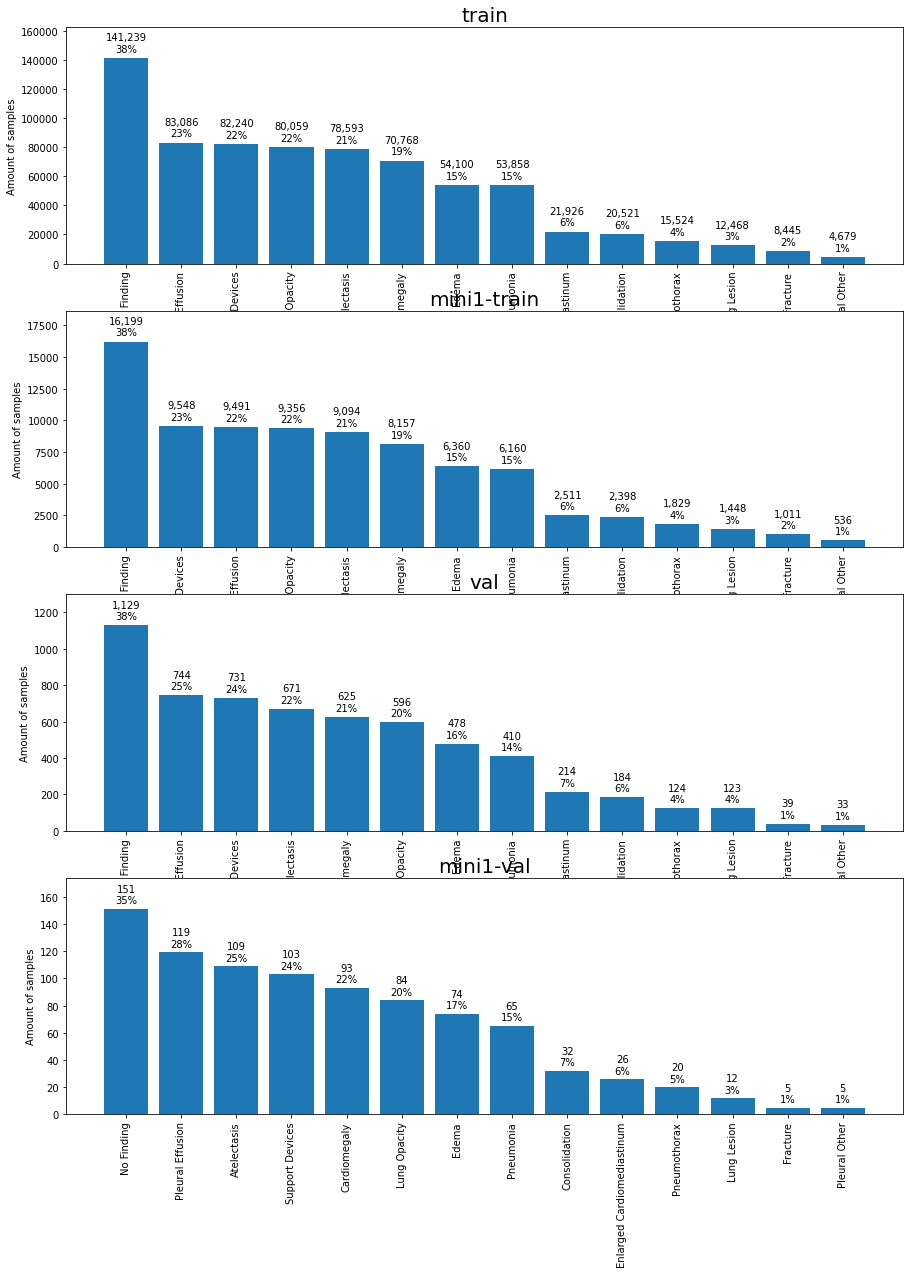

In [118]:
n_rows = 4
n_cols = 1
plt.figure(figsize=(15, n_rows * 5))

plt.subplot(n_rows, n_cols, 1)
plot_labels_distribution(train_dataset)

plt.subplot(n_rows, n_cols, 2)
plot_labels_distribution(train_dataset_mini)

plt.subplot(n_rows, n_cols, 3)
plot_labels_distribution(val_dataset)

plt.subplot(n_rows, n_cols, 4)
plot_labels_distribution(val_dataset_mini)

## Length distribution

In [108]:
def plot_n_words_distribution(dataset):
    df = dataset.master_df.groupby('report_fpath').first()
    lengths = df['report_length']
    plt.title(f'Distribution of report-length ({get_dataset_name(dataset)})')
    plt.ylabel('Amount of reports')
    plt.xlabel('Number of words')
    _ = plt.hist(lengths.values, bins=25, range=(0,200))

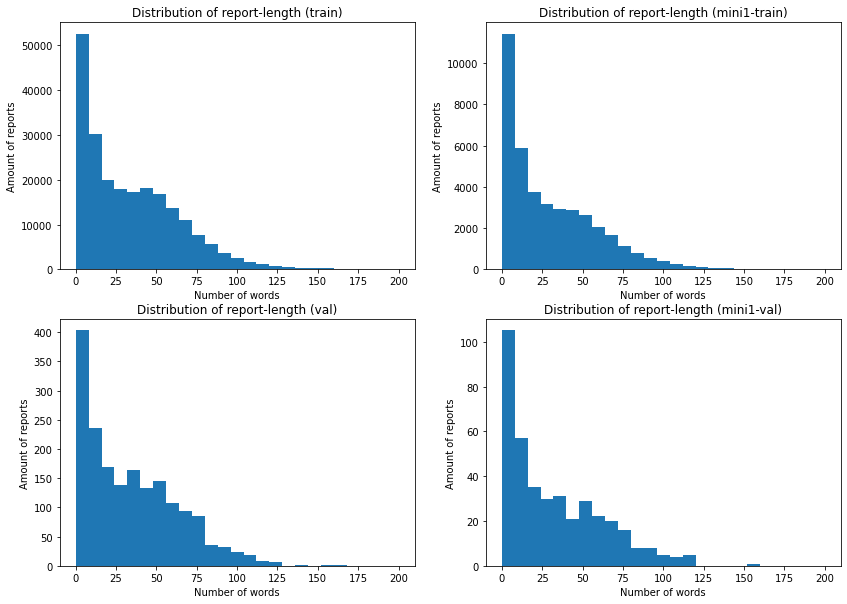

In [119]:
n_rows = 2
n_cols = 2

plt.figure(figsize=(7 * n_cols, 5*n_rows))
plt.subplot(n_rows, n_cols, 1)
plot_n_words_distribution(train_dataset)

plt.subplot(n_rows, n_cols, 2)
plot_n_words_distribution(train_dataset_mini)

plt.subplot(n_rows, n_cols, 3)
plot_n_words_distribution(val_dataset)

plt.subplot(n_rows, n_cols, 4)
plot_n_words_distribution(val_dataset_mini)

## Frontal vs lateral distribution

In [120]:
def plot_view_position_distribution(dataset):
    amounts = Counter(dataset.master_df['ViewPosition'])
    
    reduced_amounts = Counter()
    for key, value in amounts.items():
        key = str(key)
        if key == 'nan':
            reduced_key = 'nan'
        elif key in _FRONTAL_POSITIONS:
            reduced_key = 'frontal'
        else:
            reduced_key = 'lateral'
            
        reduced_amounts[reduced_key] += value
    
    plt.title(f'Frontal vs lateral ({get_dataset_name(dataset)})')
    plt.ylabel('Amount of images')
    # plt.xticks(rotation=90)
    
    reduced_amounts = sorted(reduced_amounts.items(), key=lambda x: x[1], reverse=True)
    keys, values = zip(*reduced_amounts)
    plt.bar(keys, values)
    
    plt.ylim(0, max(values) * 1.2)
    y_padding = max(values) * 0.03
    n_samples = len(dataset)
    for index, value in enumerate(values):
        perc = value / n_samples * 100
        text = f'{value:,}\n{perc:.2f}%'
        plt.text(index, value + y_padding, text, ha='center')

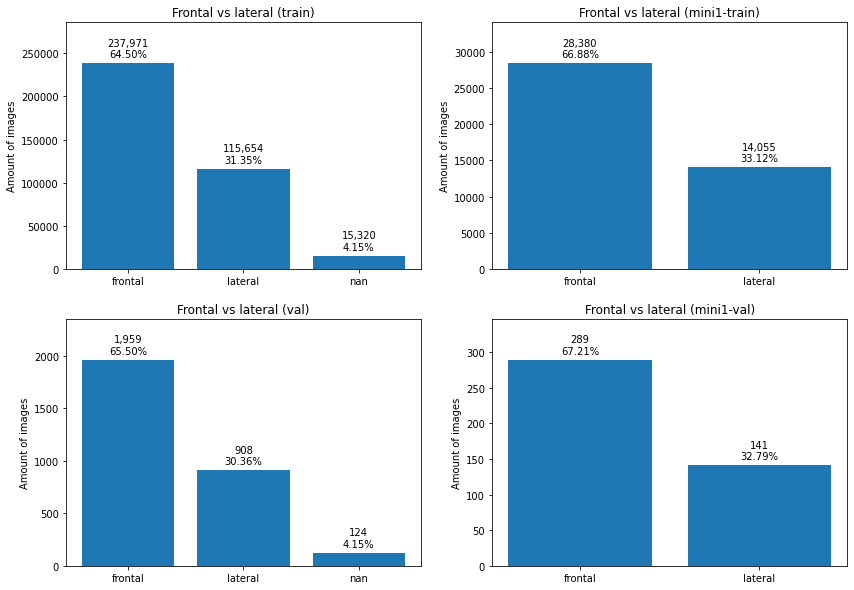

In [121]:
n_rows = 2
n_cols = 2

plt.figure(figsize=(n_cols * 7, n_rows * 5))

plt.subplot(n_rows, n_cols, 1)
plot_view_position_distribution(train_dataset)
plt.subplot(n_rows, n_cols, 2)
plot_view_position_distribution(train_dataset_mini)

plt.subplot(n_rows, n_cols, 3)
plot_view_position_distribution(val_dataset)
plt.subplot(n_rows, n_cols, 4)
plot_view_position_distribution(val_dataset_mini)